In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils

In [31]:
from pathlib import Path
current_working_directory = Path.cwd()

In [32]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J)', 'DRAM_ENERGY (J)']

In [33]:
DATAPATH = f"{current_working_directory}/../data/server_data.csv"

In [34]:
data = pd.read_csv(DATAPATH)
utils.clean_and_format_df(data)

In [7]:
data.columns

Index(['__run_id', '__done', 'subject', 'target', 'cache-references',
       'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores',
       'LLC-store-misses', 'cache-misses_percent', 'LLC-load-misses_percent',
       'LLC-store-misses_percent', 'DRAM_ENERGY (J)', 'PACKAGE_ENERGY (J)',
       'PP0_ENERGY (J)', 'PP1_ENERGY (J)', 'TOTAL_MEMORY', 'TOTAL_SWAP',
       'USED_MEMORY', 'USED_SWAP', 'execution_time', 'PROCESS_CPU_USAGE',
       'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY', 'CPU_USAGE_0',
       'CPU_USAGE_1', 'CPU_USAGE_2', 'CPU_USAGE_3', 'CPU_FREQUENCY_0',
       'CPU_FREQUENCY_1', 'CPU_FREQUENCY_2', 'CPU_FREQUENCY_3'],
      dtype='object')

In [8]:
# Convert to KJ and add Total Energy
data['PACKAGE_ENERGY (J)'] = data['PACKAGE_ENERGY (J)'] / 1000
data['DRAM_ENERGY (J)'] = data['DRAM_ENERGY (J)'] / 1000
data['PP0_ENERGY (J)'] = data['PP0_ENERGY (J)'] / 1000
data['TOTAL_ENERGY'] = data['PACKAGE_ENERGY (J)'] + data['DRAM_ENERGY (J)']
data['CACHE_ENERGY'] = data['PACKAGE_ENERGY (J)'] - data['PP0_ENERGY (J)']
data.rename(
    columns={'PACKAGE_ENERGY (J)': 'PACKAGE_ENERGY (KJ)', 'DRAM_ENERGY (J)': 'DRAM_ENERGY (KJ)', 'PP0_ENERGY (J)': 'PP0_ENERGY (KJ)' }, inplace=True
)

In [9]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J) (KJ)', 'DRAM_ENERGY (KJ)', 'TOTAL_ENERGY']

In [10]:
#subjects = list(set(data['subject'].values))
subjects = ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
targets = ['mandelbrot', 'fannkuch_redux', 'binary_trees', 'n_body', 'spectralnorm', 'k_nucleotide', 'fasta']
GROUPS = list(
    product(subjects, targets)
)

In [11]:
data['subject'] = pd.Categorical(
    data['subject'],
    ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
)

## Descriptive Statistics

### Descriptive Statistics per Benchmark

In [12]:
def reform(dictionary):
    return {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}

In [13]:
descriptive = []
for subject in subjects:
    row = {}
    row['subject'] = subject

    for target in targets:
        df = utils.get_rows_by_subject_target(data, subject, target)
        #stats = {'subject': subject, 'target' : target} | reform(df[ENERGY_METRICS].describe().to_dict())

        row[(target, 'PACKAGE')] = df['PACKAGE_ENERGY (KJ)'].mean()
        row[(target, 'DRAM')] = df['DRAM_ENERGY (KJ)'].mean()
        row[(target, 'CACHE')] = df['CACHE_ENERGY'].mean()
        row[(target, 'CPU')] = df['PP0_ENERGY (KJ)'].mean()
        
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([targets, ['CPU', 'DRAM']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(mandelbrot, PACKAGE)","(mandelbrot, DRAM)","(mandelbrot, CACHE)","(mandelbrot, CPU)","(fannkuch_redux, PACKAGE)","(fannkuch_redux, DRAM)","(fannkuch_redux, CACHE)","(fannkuch_redux, CPU)","(binary_trees, PACKAGE)",...,"(spectralnorm, CACHE)","(spectralnorm, CPU)","(k_nucleotide, PACKAGE)","(k_nucleotide, DRAM)","(k_nucleotide, CACHE)","(k_nucleotide, CPU)","(fasta, PACKAGE)","(fasta, DRAM)","(fasta, CACHE)","(fasta, CPU)"
7,codon,1.005466,0.445068,0.759278,0.246188,0.724269,0.323172,0.548285,0.175984,0.272485,...,0.055913,0.015126,0.673663,0.302561,0.505618,0.168045,0.241564,0.106962,0.181135,0.060429
0,cpython,12.666283,5.197379,9.280798,3.385485,32.616282,13.261940,23.606655,9.009626,14.658347,...,4.628612,1.808271,3.950278,1.650318,2.869619,1.080659,3.860382,1.558259,2.745385,1.114997
6,cython,10.933134,4.551181,8.111365,2.821768,23.517113,9.593737,17.118507,6.398606,12.657594,...,3.387591,1.265731,3.465569,1.460863,2.536397,0.929172,3.909680,1.598054,2.812856,1.096824
8,mypyc,11.751167,4.891253,8.695729,3.055438,31.578327,12.974213,23.081754,8.496573,4.521408,...,4.526393,1.674599,4.046222,1.698938,2.959761,1.086461,4.348555,1.769054,3.127782,1.220773
5,nuitka,9.587188,4.070900,7.146851,2.440337,23.847908,9.716649,17.427258,6.420650,12.440441,...,3.398575,1.302649,3.231845,1.366444,2.362915,0.868930,3.340076,1.356991,2.368140,0.971937
2,numba,1.260687,0.550773,0.945694,0.314993,0.750148,0.322639,0.556390,0.193758,0.720762,...,1.354995,0.396739,0.427551,0.179192,0.307428,0.120123,1.407337,0.578482,1.022865,0.384471
4,py3.13-jit,14.021623,5.726351,10.278287,3.743336,19.331939,7.839204,13.877412,5.454527,7.182095,...,3.966547,1.555059,4.442146,1.843033,3.226350,1.215796,4.176133,1.686257,2.964385,1.211748
1,pypy,2.079575,0.883197,1.549610,0.529965,1.519939,0.631477,1.109625,0.410314,1.053741,...,0.188681,0.061514,1.475449,0.691378,1.119365,0.356084,0.674099,0.310749,0.494744,0.179355
3,pyston-lite,12.308975,5.102221,9.079232,3.229742,32.376295,13.257252,23.508118,8.868178,15.475142,...,4.578305,1.776970,3.933340,1.646195,2.863929,1.069411,3.842940,1.548757,2.716895,1.126045


latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

### Aggregated Descriptive Statistics

In [14]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]
    stats = {'subject': subject} | reform(df[['PACKAGE_ENERGY (KJ)', 'DRAM_ENERGY (KJ)']].describe().to_dict())
    row = {
        'subject': subject,
        ('PACKAGE_ENERGY (KJ)', 'mean'): stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('PACKAGE_ENERGY (KJ)', 'std'): stats[('PACKAGE_ENERGY (KJ)', 'std')],
        ('PACKAGE_ENERGY (KJ)', 'CV'): stats[('PACKAGE_ENERGY (KJ)', 'std')] / stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('DRAM_ENERGY (KJ)', 'mean'): stats[('DRAM_ENERGY (KJ)', 'mean')],
        ('DRAM_ENERGY (KJ)', 'std'): stats[('DRAM_ENERGY (KJ)', 'std')],
        ('DRAM_ENERGY (KJ)', 'CV'): stats[('DRAM_ENERGY (KJ)', 'std')] / stats[('DRAM_ENERGY (KJ)', 'mean')]
    }
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([ENERGY_METRICS, ['mean', 'std', 'min', '50%', 'max']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(PACKAGE_ENERGY (KJ), mean)","(PACKAGE_ENERGY (KJ), std)","(PACKAGE_ENERGY (KJ), CV)","(DRAM_ENERGY (KJ), mean)","(DRAM_ENERGY (KJ), std)","(DRAM_ENERGY (KJ), CV)"
7,codon,0.437588,0.338887,0.774444,0.198597,0.148690,0.748700
0,cpython,11.436791,9.124568,0.797826,4.972373,3.896041,0.783538
6,cython,10.372378,6.706617,0.646584,4.556177,2.930576,0.643210
8,mypyc,10.609186,9.214053,0.868498,4.477498,3.721742,0.831210
5,nuitka,9.932504,6.829561,0.687597,4.385494,2.983355,0.680278
2,numba,0.925580,0.529556,0.572134,0.408962,0.233986,0.572147
4,py3.13-jit,8.857123,5.304078,0.598849,3.718331,2.137127,0.574754
1,pypy,1.061576,0.624947,0.588698,0.477306,0.269501,0.564630
3,pyston-lite,11.746407,9.443885,0.803981,5.119900,4.058609,0.792713


## BarPlots

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
darker_colors = [
    "#BA3636",  # Enhanced Darker Coral Red
    "#30928C",  # Enhanced Darker Turquoise
    "#DC6E45",  # Enhanced Darker Light Salmon
    "#462865",  # Enhanced Darker Purple
    "#BEA200",  # Enhanced Darker Gold
    "#2E859C",  # Enhanced Darker Sky Blue
    "#6BA393",  # Enhanced Darker Mint
    "#C13E8A",  # Enhanced Darker Hot Pink
    "#5F300D"   # Enhanced Darker Saddle Brown
]

colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

brighter_colors = [
    "#FFB3B3",  # Enhanced Brighter Coral Red
    "#B3FFE6",  # Enhanced Brighter Turquoise
    "#FFD6B3",  # Enhanced Brighter Light Salmon
    "#D6B3FF",  # Enhanced Brighter Purple
    "#FFFFB3",  # Enhanced Brighter Gold
    "#B3E6FF",  # Enhanced Brighter Sky Blue
    "#E6FFE6",  # Enhanced Brighter Mint
    "#FFB3D9",  # Enhanced Brighter Hot Pink
    "#D6B399"   # Enhanced Brighter Saddle Brown
]


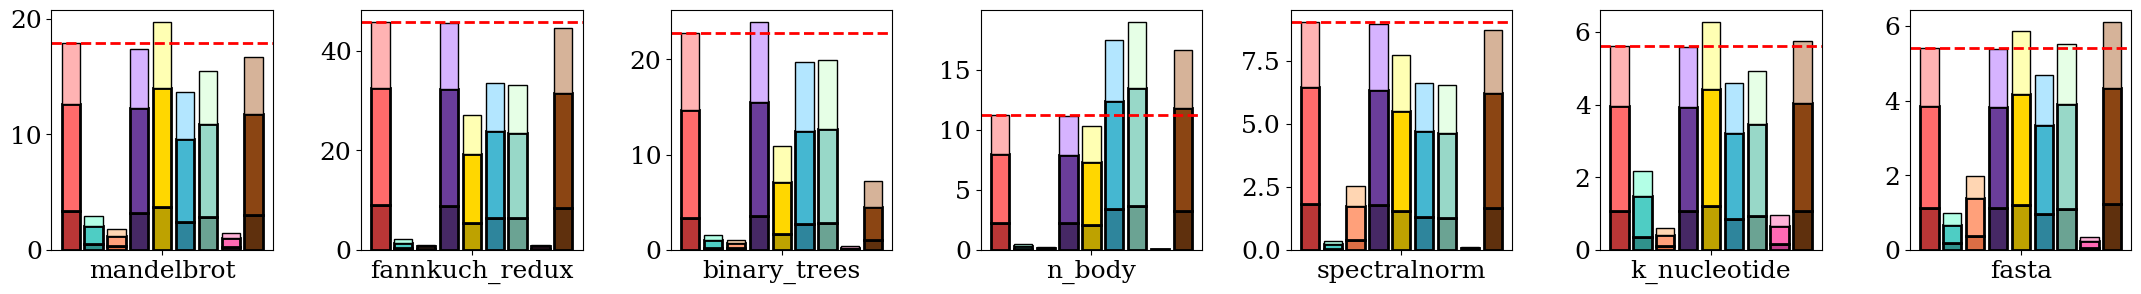

In [17]:
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    #df = df.sort_values(by='subject')

    total_energy = df.groupby('subject')['PP0_ENERGY (KJ)'].mean()
    cache_energy = df.groupby('subject')['CACHE_ENERGY'].mean()
    dram_energy = df.groupby('subject')['DRAM_ENERGY (KJ)'].mean()

    # Plot stacked bars
    axs_flat[i].bar(total_energy.index, total_energy, label='PP0_ENERGY', color=darker_colors, edgecolor='black', linewidth=2)
    axs_flat[i].bar(cache_energy.index, cache_energy, bottom=total_energy, label='CACHE_ENERGY', color=colors, edgecolor='black',  linewidth=2)
    axs_flat[i].bar(dram_energy.index, dram_energy, bottom=total_energy + cache_energy, label='DRAM_ENERGY', color=brighter_colors, edgecolor='black',  linewidth=1)
    # Add horizontal line on top of the first bar at the left
    first_bar_height = total_energy.iloc[0] + cache_energy.iloc[0] + dram_energy.iloc[0]
    axs_flat[i].axhline(y=first_bar_height, color='red', linestyle='--', linewidth=2)
    # Set target as single x tick in the middle
    axs_flat[i].set_xticks([len(total_energy) // 2])
    axs_flat[i].set_xticklabels([targets[i]], fontsize=18)
    
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')

plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"gl2_energy_stacked.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

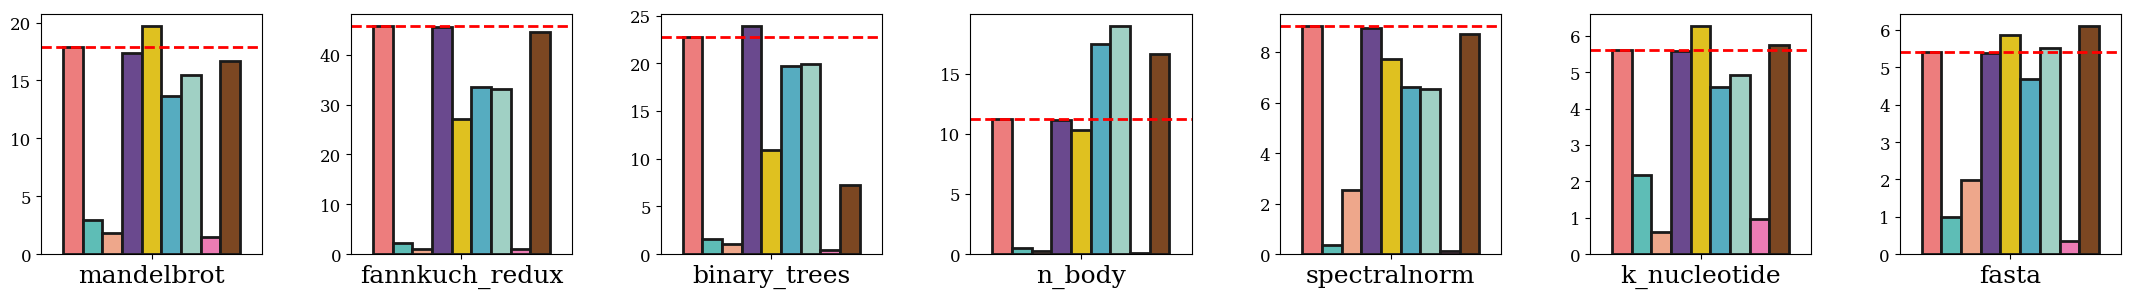

In [18]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df.sort_values(by='subject')

    sns.barplot(
        x="target", y='TOTAL_ENERGY', hue="subject", capsize = 0.5, errorbar=None, edgecolor = '0.1', lw=2, data=df, ax = axs_flat[i], dodge=True,
        palette=colors
    )
    axs_flat[i].get_legend().remove()
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')
    axs_flat[i].tick_params(axis='x', labelsize=18)
    
    first_bar = axs_flat[i].patches[0]
    bar_height = first_bar.get_height()
    axs_flat[i].axhline(y=bar_height, color='red', linestyle='--', linewidth=2)
        
plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"gl2_energy.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

## Normality

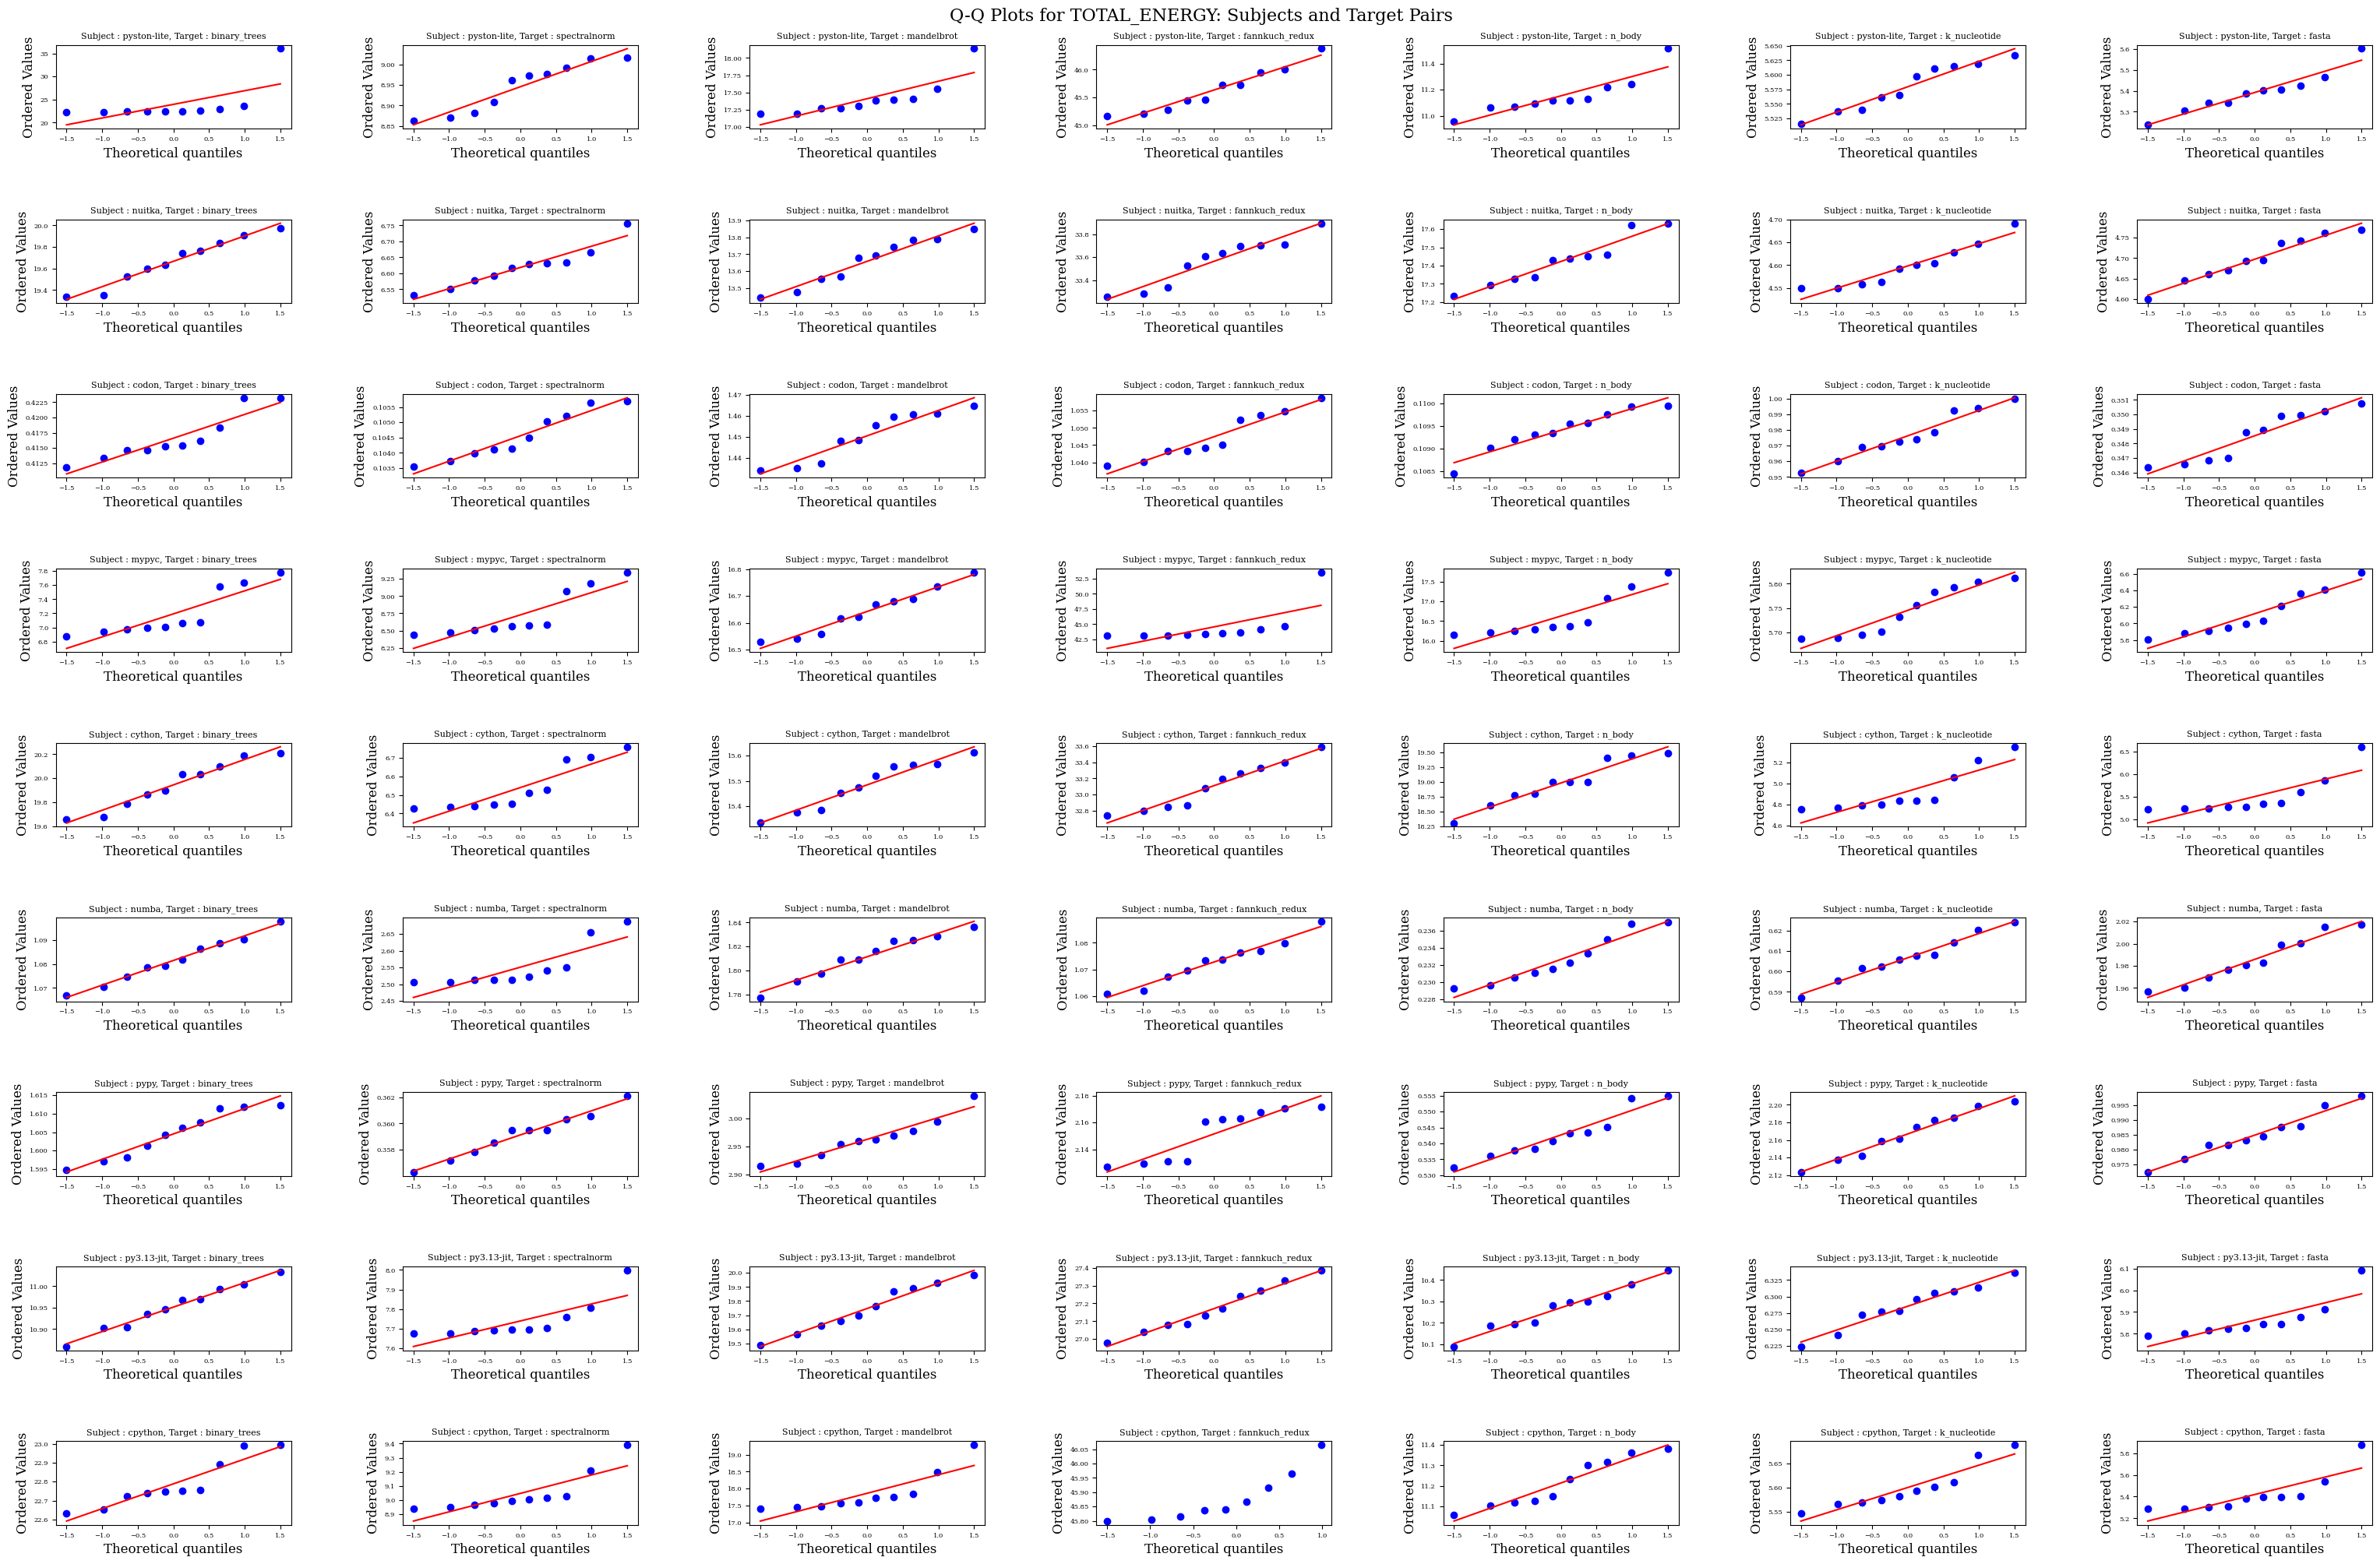

In [19]:
utils.plot_qq_grid(data, 'TOTAL_ENERGY')

### Shapiro-Wilk Aggregated 

In [20]:
from scipy import stats

In [21]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    print(subject, p_value)

cpython nan
pypy 2.4970400260975734e-05
numba 0.00017777589791145528
pyston-lite 3.8400573263596455e-09
py3.13-jit 9.916125825438588e-09
nuitka 2.2028308487439389e-07
cython 3.2627367892489854e-07
codon 4.841120391729496e-07
mypyc 7.172690681040857e-11


### Shapiro-Wilk per Benchmark

In [22]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    row = {'subject': subject, 'target' : target, 'p-value' : p_value, 'normal?' : 'normal' if p_value > 0.05 else 'maybe not'}
    descriptive.append(row)

pd.DataFrame(descriptive)

,subject,target,p-value,normal?
0,cpython,mandelbrot,0.002841,maybe not
1,cpython,fannkuch_redux,NaN,maybe not
2,cpython,binary_trees,0.093189,normal
3,cpython,n_body,0.257467,normal
4,cpython,spectralnorm,0.001689,maybe not
...,...,...,...,...
58,mypyc,binary_trees,0.009149,maybe not
59,mypyc,n_body,0.011406,maybe not
60,mypyc,spectralnorm,0.006037,maybe not
61,mypyc,k_nucleotide,0.116895,normal


## Kruskal

In [23]:
from scipy.stats import kruskal

In [24]:
samples = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    samples.append(df.to_list())

stat, p_value = kruskal(*samples)
print({'stat': stat, 'p_value': p_value})

{'stat': nan, 'p_value': nan}


## Cliffs Delta

In [25]:
from cliffs_delta import cliffs_delta
import itertools

In [26]:
# Baseline - CPython Group
baseline = [utils.get_rows_by_subject_target(data, 'cpython', target)['TOTAL_ENERGY'].to_list() for target in targets]
baseline = list(itertools.chain(*baseline))

In [27]:
rows = []
for subject in subjects:
    sample = [utils.get_rows_by_subject_target(data, subject, target)['TOTAL_ENERGY'].to_list() for target in targets]
    sample = list(itertools.chain(*sample))
    value, difference = cliffs_delta(baseline, sample)
    row = {'subject': subject, 'value': value, 'difference': difference}
    rows.append(row)

cliffs = pd.DataFrame(rows)
cliffs

,subject,value,difference
0,cpython,-0.264490,small
1,pypy,1.000000,large
2,numba,1.000000,large
3,pyston-lite,0.768571,large
4,py3.13-jit,0.836735,large
5,nuitka,0.790204,large
6,cython,0.758367,large
7,codon,1.000000,large
8,mypyc,0.836327,large


In [28]:
latex_table = cliffs.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{lrl}
\toprule
subject & value & difference \\
\midrule
cpython & -0.26 & small \\
pypy & 1.00 & large \\
numba & 1.00 & large \\
pyston-lite & 0.77 & large \\
py3.13-jit & 0.84 & large \\
nuitka & 0.79 & large \\
cython & 0.76 & large \\
codon & 1.00 & large \\
mypyc & 0.84 & large \\
\bottomrule
\end{tabular}

